Deal with unlabeled bbox (remove car IDs)
Goal: associate measurements to unique objects
1. try stitching objects in mutl-camera road

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import data_association as da
importlib.reload(da)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA
from shapely.geometry import Polygon


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# read and preprocess data
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June_5min')
tform_path = pathlib.Path().absolute().joinpath('../tform')

file_path = data_path.joinpath('p1c1_1_track_outputs_3D.csv')
df = utils.preprocess(file_path, tform_path)


Reading data...


KeyError: 'ID'

In [72]:
# stitching based on prediction and overlaps

import utils
importlib.reload(utils)

df = utils.preprocess_data_association(df)


Before DA:  203 cars
Frame :    0
Frame :  100
Frame :  200
Frame :  300
Frame :  400
Frame :  500
Frame :  600
Frame :  700
Frame :  800
Frame :  900
Frame : 1000
Frame : 1100
Frame : 1200
Frame : 1300
Frame : 1400
Frame : 1500
Frame : 1600
Frame : 1700
135 cars after object stitching
After stitching:  135 cars
After assocating overlaps:  88 cars
Get the longest continuous frame chunk...


100%|██████████████████████████████████████████████████████████████████████████████| 1791/1791 [00:18<00:00, 98.11it/s]


In [73]:
# try rectification
import utils_optimization as opt
importlib.reload(opt)
df = opt.rectify(df) # parallel, batch method

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [01:07<00:00,  1.31it/s]


In [75]:
df = utils.post_process(df)

cap width at 2.59m...
standardize format for plotter...


In [76]:
df.to_csv('../rectified_p1c2_uncorrected.csv',index=False)

In [4]:
import importlib
import animation_utils as an
importlib.reload(an)
image_folder = '../FramePic'
if len(df['camera'].unique())==1:
    dim0 = get_camera_range(df['camera'][0])
else:
    dim0 = get_camera_range('all')
print(dim0)
dim = [d * 3.281 for d in dim0] # convert meter to feet
an.generate_frames(df, dim, skip_frame=1, image_folder=image_folder)

(100, 220, -5, 45)
Frame:  0 1790


In [5]:
# Fetch image files from the folder, and create an animation.
importlib.reload(an)
video_name = '../p1c2_uncorrected_DA.mp4'
an.write_video(image_folder, video_name, fps=10)

In [3]:
# visualize footprint on the camera video

import plot_rectified_objects
importlib.reload(plot_rectified_objects)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4')
video = str(data_path.joinpath('p1c2_00000.mp4'))
label_file = str(data_path.joinpath('rectified/uncorrected_individual/rectified_p1c2_uncorrected.csv')) 
# # label_file = str(data_path.joinpath('rectified/p1_all/rectified_p1c3.csv')) 
# # label_file = str(data_path.joinpath('rectified/uncorrected_individual/rectified_p1c3_uncorrected.csv'))
# # label_file = str(data_path.joinpath('rectified/uncorrected_all/rectified_p1c3.csv'))
plot_rectified_objects.plot_vehicle_csv(video,label_file, frame_rate = 10,show_2d = False,show_3d = True,show_LMCS = True,show_rectified = False, ds=True)


In [21]:
df = utils.road_to_img(df, tform_path)
groups = df.groupby('camera_post')

# ... saving ...
for camera_id, group in groups:
    new_name = 'rectified_' + camera_id + 'uncorrected' +'.csv'
    group
    group.to_csv(new_name)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# read & rectify each camera df individually
import utils
importlib.reload(utils)
data_path = pathlib.Path().absolute().joinpath('../June 2021 Data - 1 minute 5 cameras w RAV 4/')
tform_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021/i24-roadway-transforms-main/tform')

# df = pd.DataFrame()
for root,dirs,files in os.walk(str(data_path), topdown = True):
    for file in files:
        if file.endswith(".csv") and file.startswith('p1c6'):
            
            # ... reading ...
            file_name = data_path.joinpath(file)
            camera_id = utils.find_camera_name(file)
            print('reading ',camera_id,'...')
            
            # ... preprocessing ...
            df = utils.preprocess(file_name, tform_path)
            df = df.assign(camera=camera_id)
            df = df.sort_values(by=['Frame #','Timestamp']).reset_index(drop=True)
        
            # ... rectifying ...
            df = opt.rectify(df)
            
            # ... post processing ...
            dfpp = utils.post_process(df)
            dfpp_img = utils.road_to_img(dfpp, tform_path)
            
            # ... saving ...
            new_name = 'rectified_' + camera_id +'.csv'
            dfpp_img.to_csv(new_name)
    break

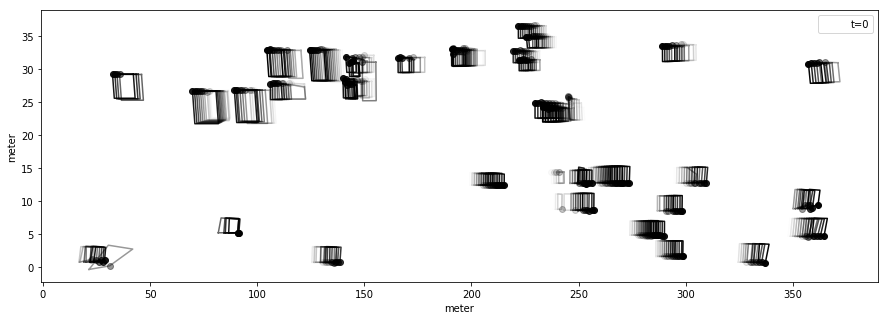

In [11]:
# try known number of objects
# plot 
import utils
importlib.reload(utils)
D = np.array(df[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
utils.plot_track(D,15,5)

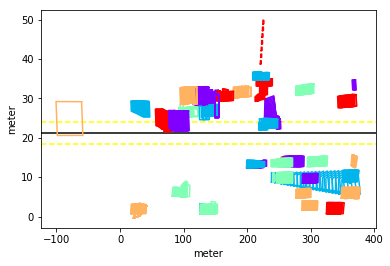

In [62]:
fig, ax = plt.subplots()
# plt.xlim(xmin, xmax)
# plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=cm.rainbow(np.linspace(0,1,5))

# frameSnap = np.array(group[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
for carid, track in tracks.items():
    frameSnap = track
    c = carColors[carid%5]
    for j in range(len(frameSnap)):  # draw one vehicle onto the plot
    #     carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
        coord = frameSnap[j,0:8]   # Finding the coordinates of the car
        if (np.isnan(coord).any()):
            print('nan')
            continue
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0])
        xs, ys = zip(*coord)
        plt.plot(xs,ys,c=c,label=carid if j==0 else '')
        #     plt.text(frameSnap[j,1], frameSnap[j,2], carID)
#     plt.legend()


No handles with labels found to put in legend.


0
1


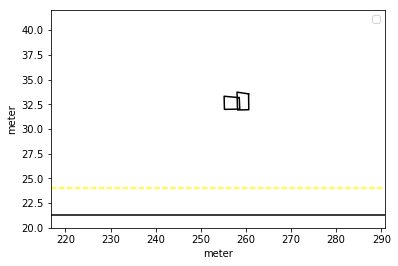

In [129]:
# for debugging

fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(20, 42) # 0, 42
plt.xlabel('meter')
plt.ylabel('meter')
#plot design setup
plt.axhline(y = 21.25, color = 'black', linestyle = 'solid')
plt.axhline(y = 24, color = 'yellow', linestyle = '--')
plt.axhline(y = 18.5, color = 'yellow', linestyle = '--')
carColors=cm.rainbow(np.linspace(0,1,5))

# frameSnap = df.loc[(df['ID'] == 2261)]
# frameSnap = df.loc[(df['Frame #'] >= 89)&(df['Frame #'] <= 89)]
# extract the ID & road coordinates of the bottom 4 points of all vehicles at frame # i
# print(frameSnap['ID'])
# frameSnap = np.array(frameSnap[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
frameSnap = np.vstack([x[2],y[0]])

for j in range(len(frameSnap)):  # draw one vehicle onto the plot
    print(j)
#     carID = int(frameSnap[j,0])  # Finding the unique carID for each vehicle in the frame
    coord = frameSnap[j,0:8]   # Finding the coordinates of the car
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0])
    xs, ys = zip(*coord)
    plt.plot(xs,ys,c='black')
    #     plt.text(frameSnap[j,1], frameSnap[j,2], carID)
plt.legend()


In [40]:
# calculate the distribution of scores of the original data
carID = 230261
car = df[df['ID']==carID]
f_start = car['Frame #'].values[0] + 2
f_end = car['Frame #'].values[-1]
for k in range(f_start+20,f_start+50):
    x_prev2 = car[(car['Frame #'] >= k-1) & (car['Frame #'] <=k)] # k-1 and k
    x_prev2 = np.array(x_prev2[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    x_pred = x_prev2[-1,:] + x_prev2[-1,:] - x_prev2[0,:] # k+1
    iou = []
    y_next = df[(df['Frame #'] == k+1)] # all measurements at k+1
    id_next = y_next['ID'].values
    y_next = np.array(y_next[['bbr_x','bbr_y','fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    for i in range(len(y_next)):
        iou.append(IOU_score(x_pred, y_next[i,:]))
    scores = score(x_pred,y_next,'xy')
    print(id_next)
    print('scores:', scores)
    print('iou: ',iou)
# frames that carID is in

IllegalArgumentException: Points of LinearRing do not form a closed linestring
Shell is not a LinearRing


[230261]
scores: [0.49377669]
iou:  [0.7443470872604031]
[212261 230261]
scores: [53.09269277  0.47096816]
iou:  [0, 0.8083938310584959]
[212261 230261]
scores: [49.69589942  0.48047282]
iou:  [0, 0.900063554287454]
[212261 230261]
scores: [46.72367816  0.37460072]
iou:  [0, 0.9101096233475444]
[212261 230261]
scores: [43.21764812  0.10596647]
iou:  [0, 0.9358044433175551]
[212261 230261]
scores: [40.26311668  0.06749591]
iou:  [0, 0.958877411213823]
[212261 230261]
scores: [37.56745512  0.05706421]
iou:  [0, 0.9725153925014971]
[212261 230261]
scores: [35.29922229  0.08685668]
iou:  [0, 0.9457102331934328]
[212261 230261]
scores: [33.59492491  0.0695719 ]
iou:  [0, 0.9719665936461728]
[212261 230261]
scores: [32.48212475  0.12174321]
iou:  [0, 0.9401586123192597]
[212261 230261]
scores: [31.83416967  0.12387221]
iou:  [0, 0.9293454035798382]
[212261 230261]
scores: [32.14303018  0.21314365]
iou:  [0, 0.8959937135543852]
[212261 230261]
scores: [32.69793935  0.19826548]
iou:  [0, 0.912

ValueError: Null geometry supports no operations